Prophet example.

Note: this is **not** fair to Prophet. Prophet defaults to a well defined business cycle: trend, seasonality, day of week, and so on. These are aspects of the finance problems Prophet is designed to solve. They are not aspects of our artificial problem.



## Setting up our example

In [1]:
# set up Python
import numpy as np
import pandas as pd
from prophet import Prophet
import plotnine
from plotnine import *
from nested_model_fns import plot_model_quality

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

## Prophet

### Prophet without external regressors

In [3]:
# https://facebook.github.io/prophet/docs/quick_start.html#python-api
m = Prophet()

In [4]:
test_date = pd.to_datetime("2024-10-30").date()
train_date = test_date - pd.to_timedelta(d_train.shape[0] + 1, unit="days")

In [5]:
d_train_p = pd.DataFrame(
    {
        "ds": [
            train_date + pd.to_timedelta(i, unit="days")
            for i in range(d_train.shape[0])
        ],
        "y": d_train["y"],
    }
)

d_train_p

,ds,y
0,2022-02-22,63.273288
1,2022-02-23,80.079317
2,2022-02-24,65.403274
3,2022-02-25,66.425156
4,2022-02-26,80.815189
...,...,...
975,2024-10-24,9.283186
976,2024-10-25,10.085011
977,2024-10-26,12.962078
978,2024-10-27,30.791449


In [6]:
m.fit(d_train_p)

10:12:35 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=d_test.shape[0])
forecast = m.predict(future)

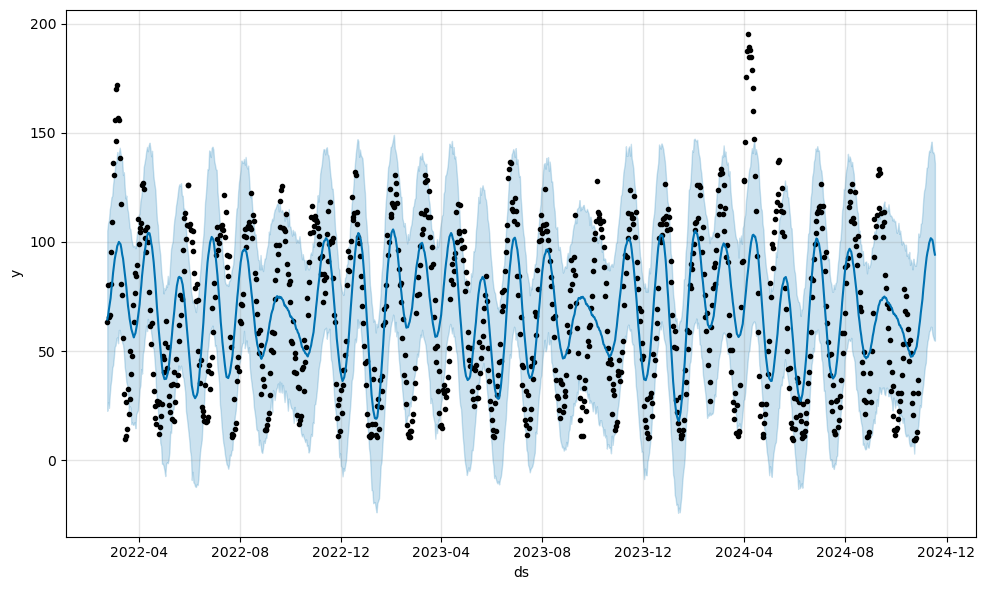

In [8]:
_ = m.plot(forecast)

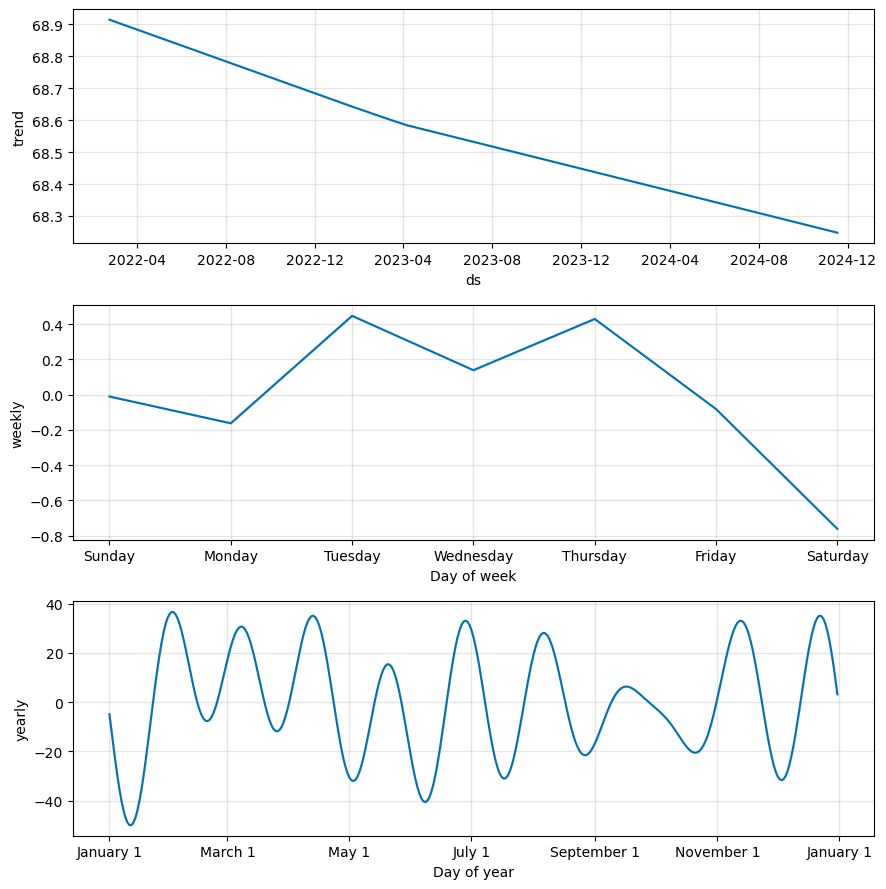

In [9]:
_ = m.plot_components(forecast)

In [10]:
forecast.shape

(1000, 19)

In [11]:
d_train.shape

(980, 5)

In [12]:
d_test.shape

(20, 5)

In [13]:
d_test["Prophet prediction (no external regressors)"] = np.array(
    forecast.loc[range(d_train.shape[0], d_train.shape[0] + d_test.shape[0]), "yhat"]
)

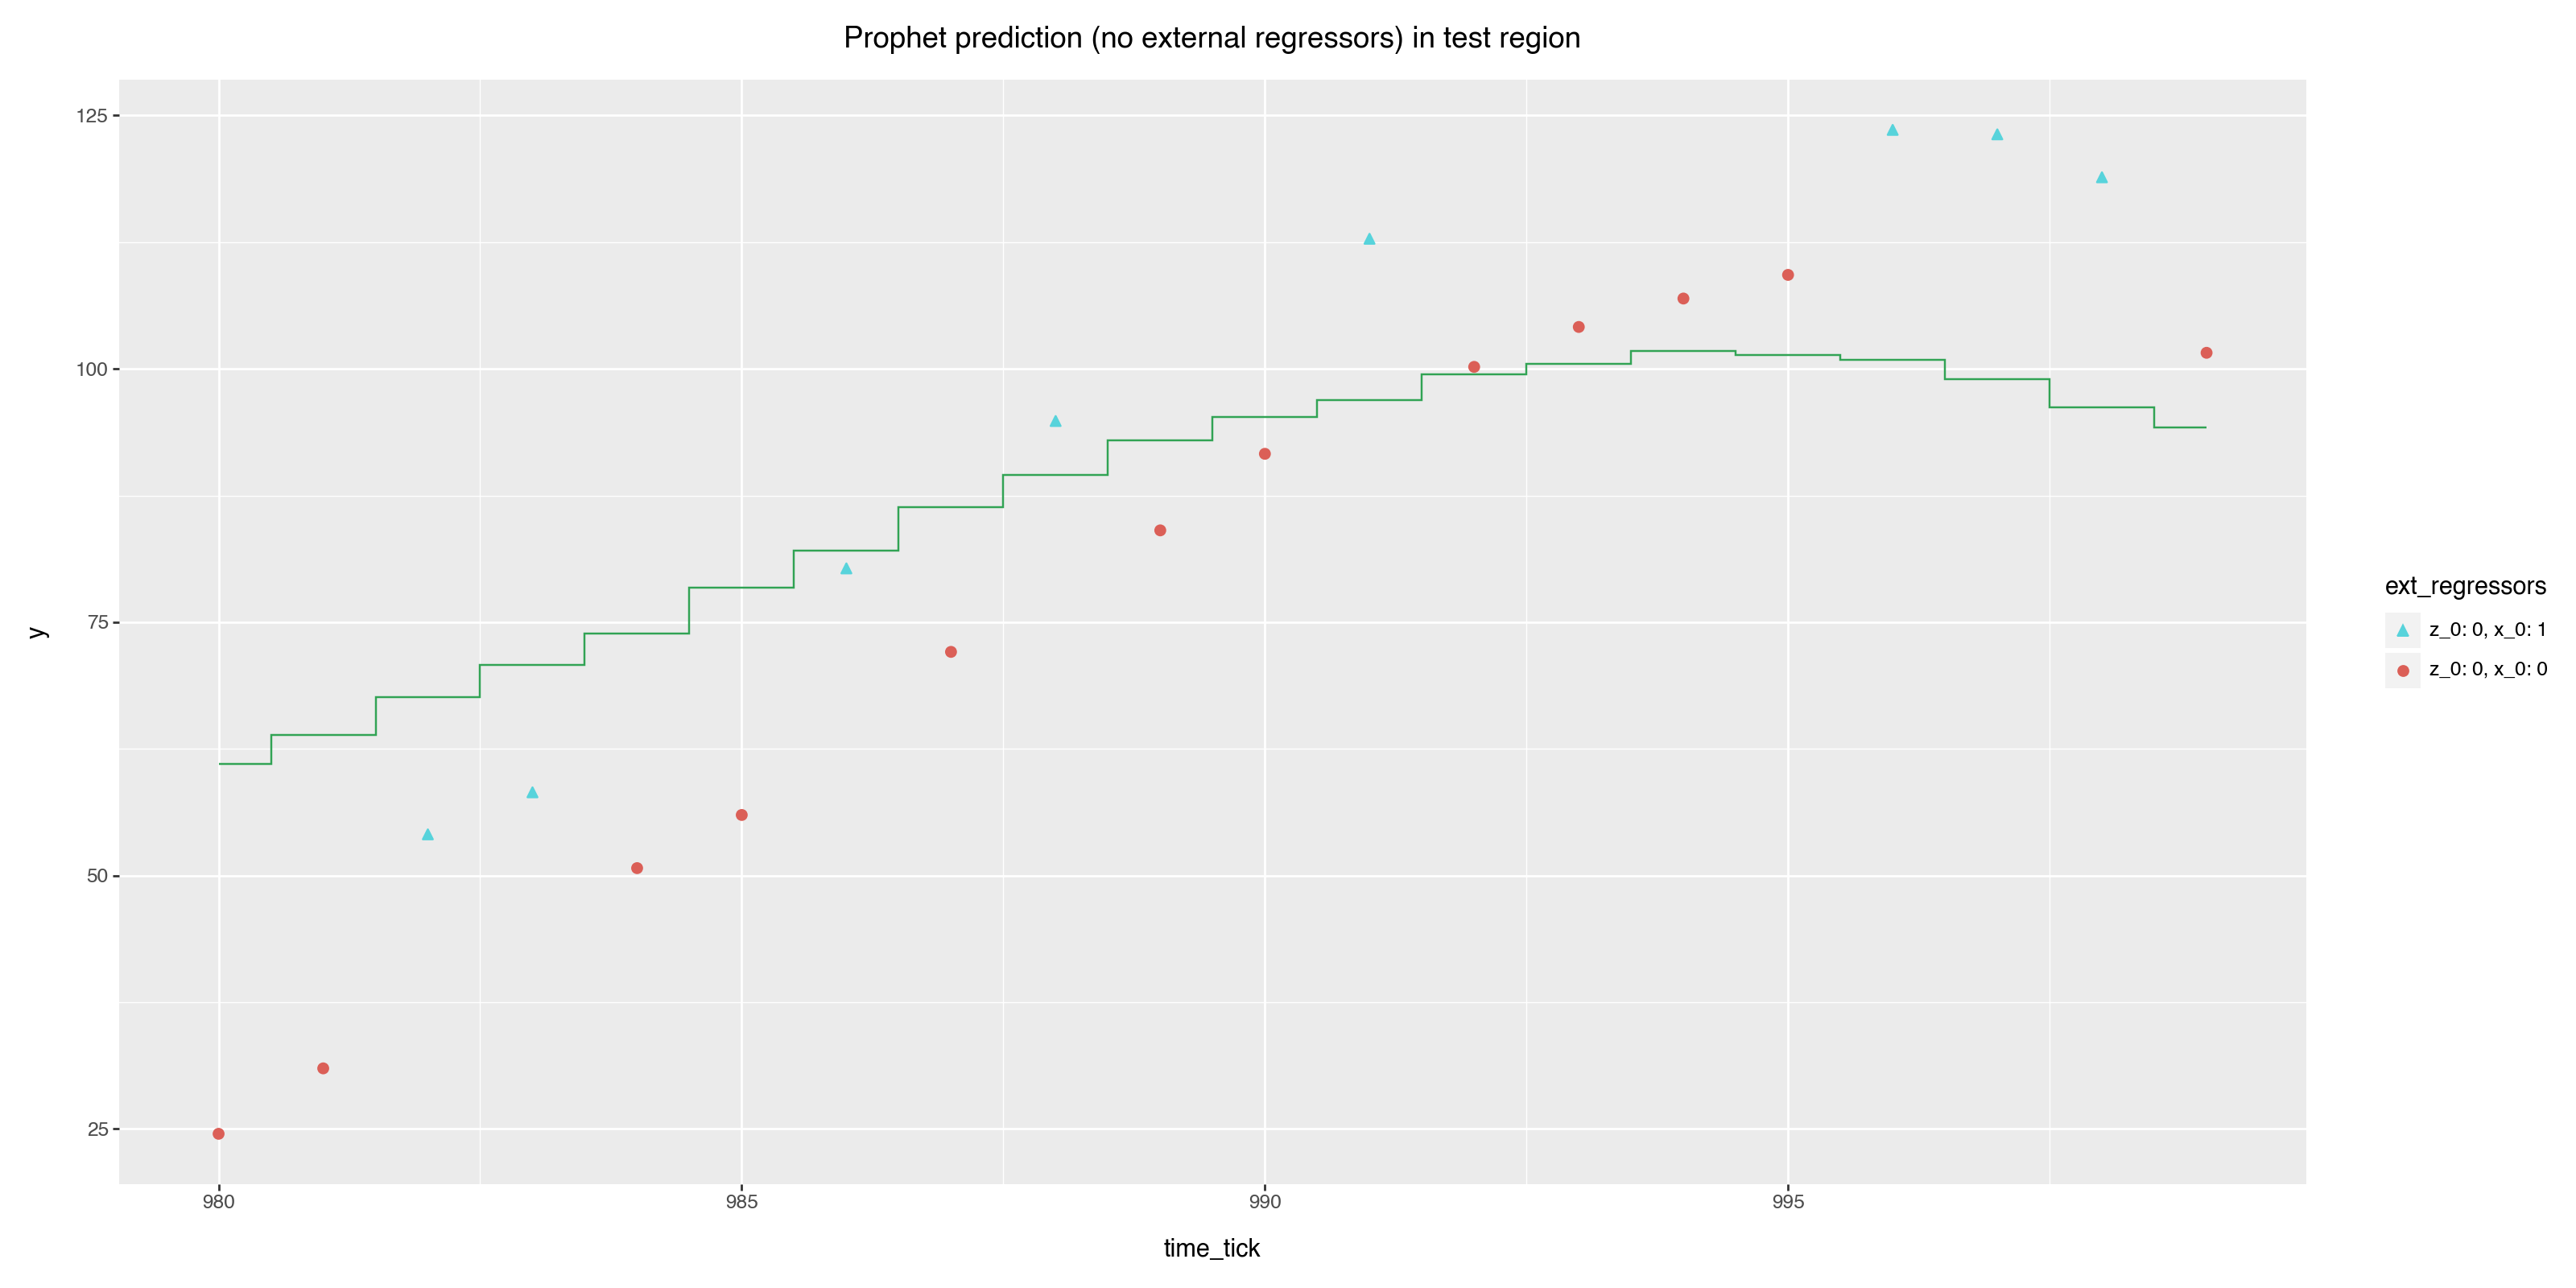

In [14]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(
        aes(y="y", shape="ext_regressors", color="ext_regressors"),
        size=2,
    )
    + geom_step(
        aes(y="Prophet prediction (no external regressors)"),
        color="#31a354",
        direction="mid",
    )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("Prophet prediction (no external regressors) in test region")
)

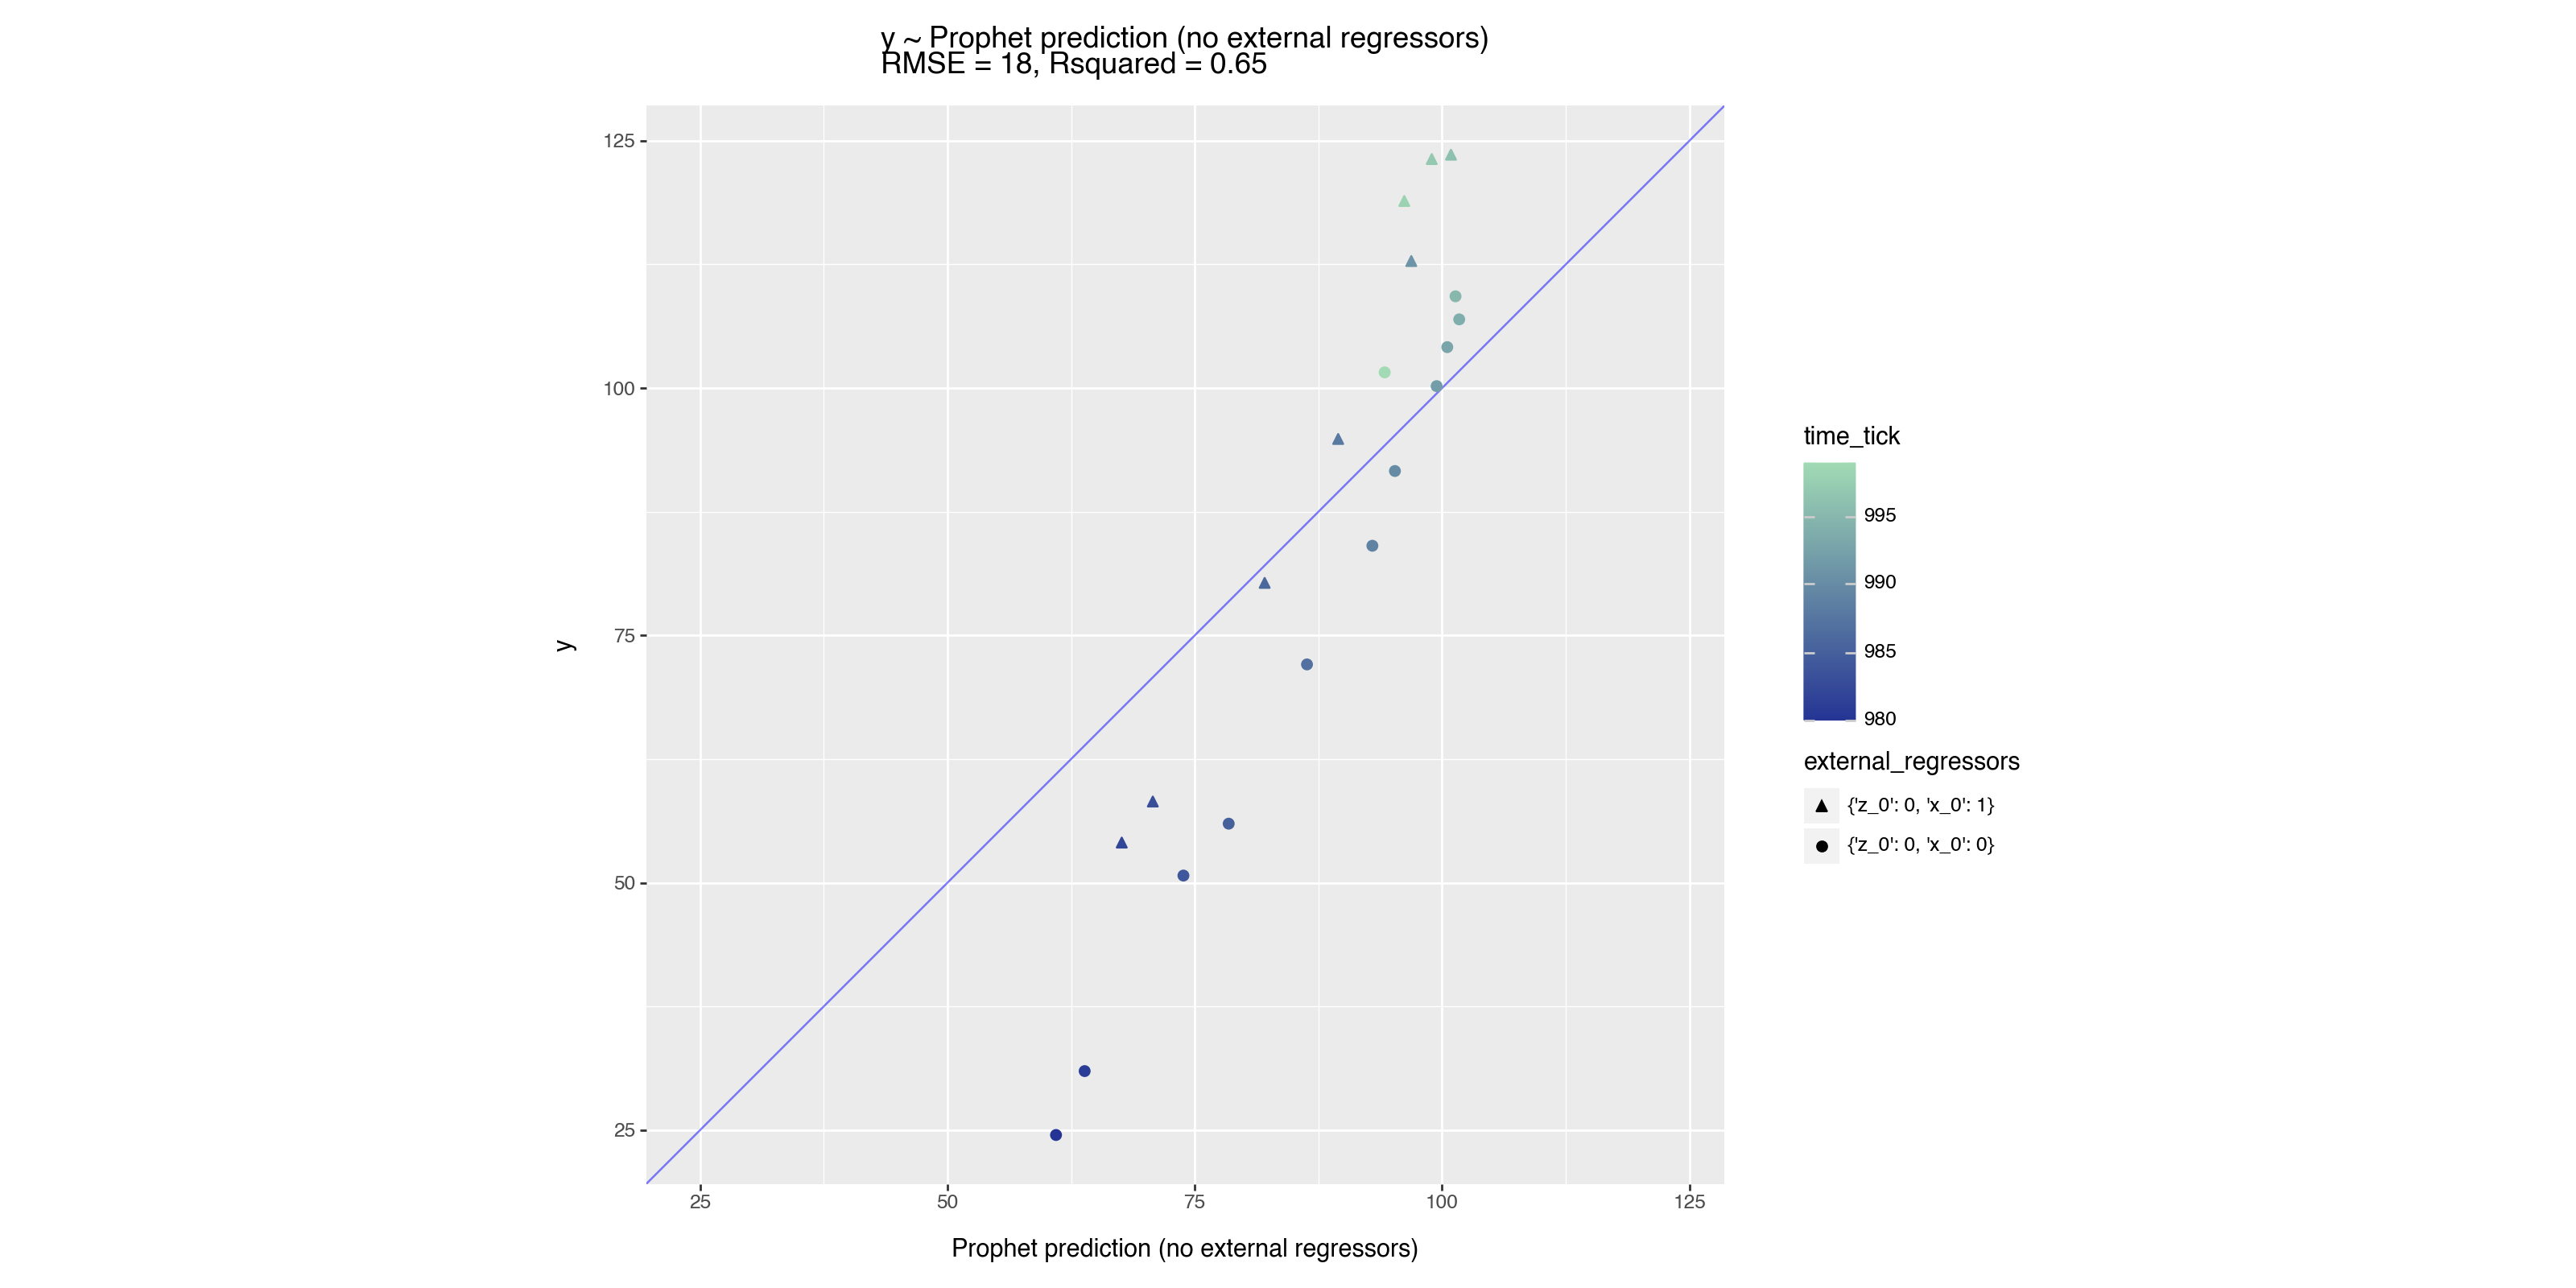

In [15]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["Prophet prediction (no external regressors)"]) == False, :
    ],
    result_name="Prophet prediction (no external regressors)",
    external_regressors=["z_0", "x_0"],
)

### Prophet with external regressors

In [16]:
m_ext = Prophet()
m_ext.add_regressor("z_0")
m_ext.add_regressor("x_0")

In [17]:
test_date = pd.to_datetime("2024-10-30").date()
train_date = test_date - pd.to_timedelta(d_train.shape[0] + 1, unit="days")

In [18]:
d_train_p = pd.DataFrame(
    {
        "ds": [
            train_date + pd.to_timedelta(i, unit="days")
            for i in range(d_train.shape[0])
        ],
        "y": d_train["y"],
        "z_0": d_train["z_0"],
        "x_0": d_train["x_0"],
    }
)

d_train_p

,ds,y,z_0,x_0
0,2022-02-22,63.273288,0,0
1,2022-02-23,80.079317,0,1
2,2022-02-24,65.403274,0,0
3,2022-02-25,66.425156,0,0
4,2022-02-26,80.815189,1,0
...,...,...,...,...
975,2024-10-24,9.283186,0,0
976,2024-10-25,10.085011,0,0
977,2024-10-26,12.962078,0,0
978,2024-10-27,30.791449,0,1


In [19]:
m_ext.fit(d_train_p)

10:12:38 - cmdstanpy - INFO - Chain [1] start processing
10:12:38 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future_ext = m_ext.make_future_dataframe(periods=d_test.shape[0])
future_ext["z_0"] = pd.concat([d_train["z_0"], d_test["z_0"]], ignore_index=True)
future_ext["x_0"] = pd.concat([d_train["x_0"], d_test["x_0"]], ignore_index=True)

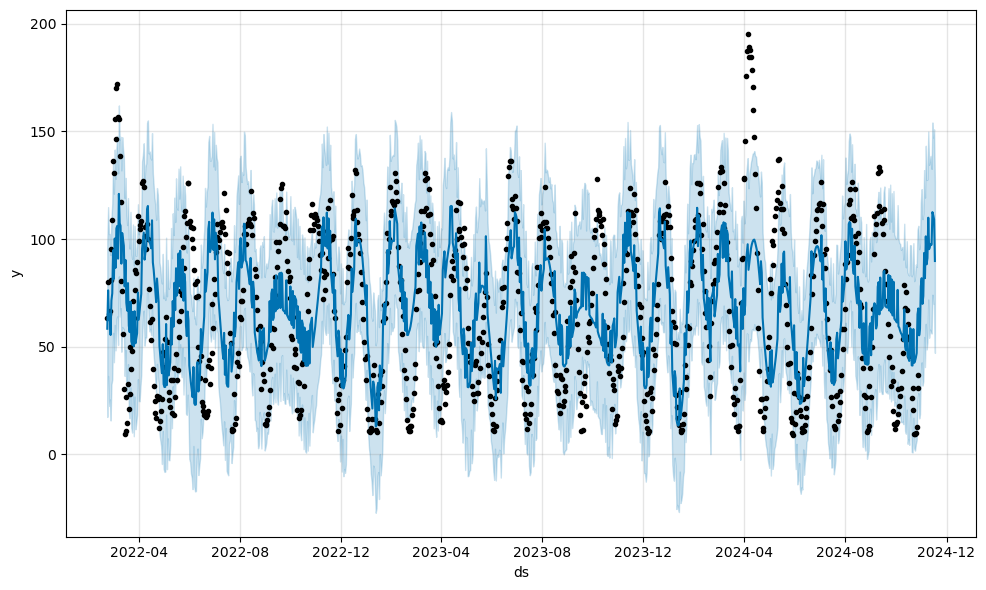

In [21]:
forecast_ext = m_ext.predict(future_ext)
_ = m_ext.plot(forecast_ext)

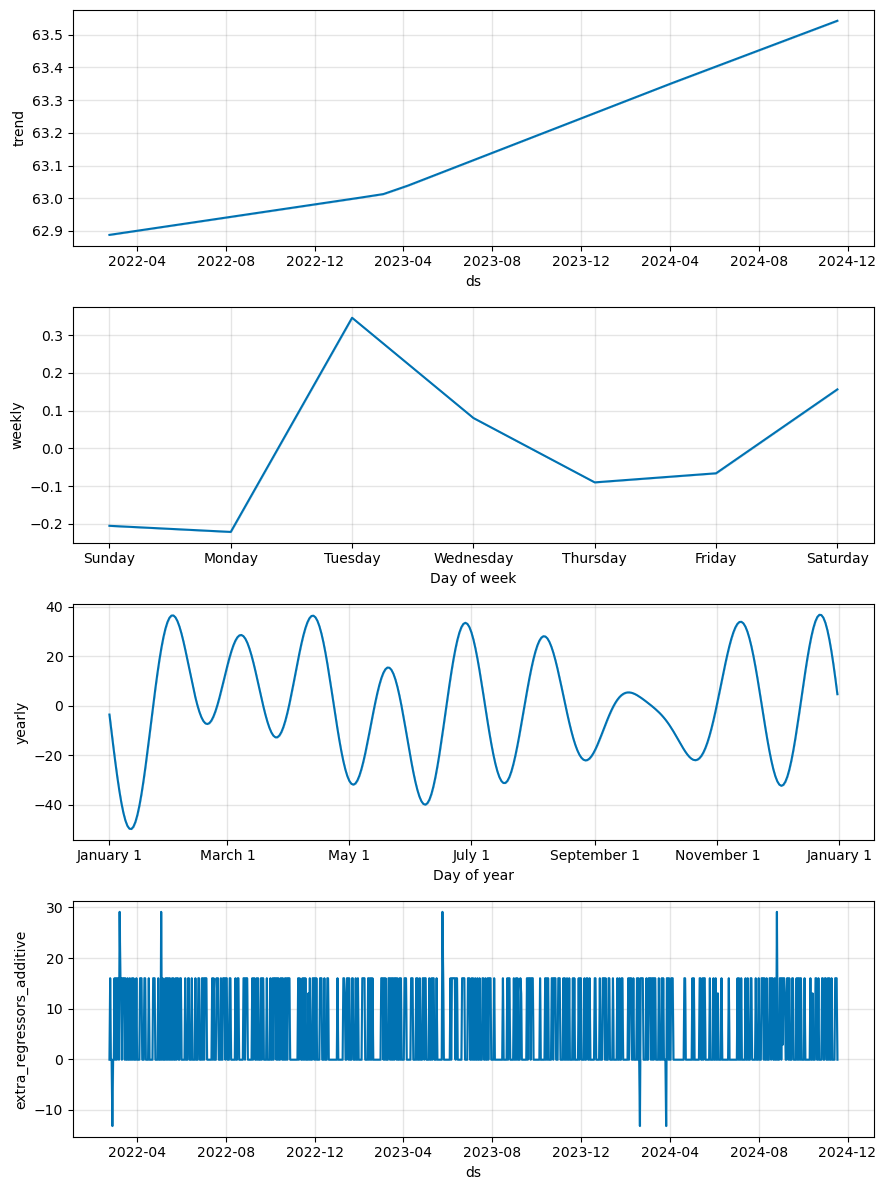

In [22]:
_ = m_ext.plot_components(forecast_ext)

In [23]:
d_test["Prophet prediction (with external regressors)"] = np.array(
    forecast_ext.loc[
        range(d_train.shape[0], d_train.shape[0] + d_test.shape[0]), "yhat"
    ]
)

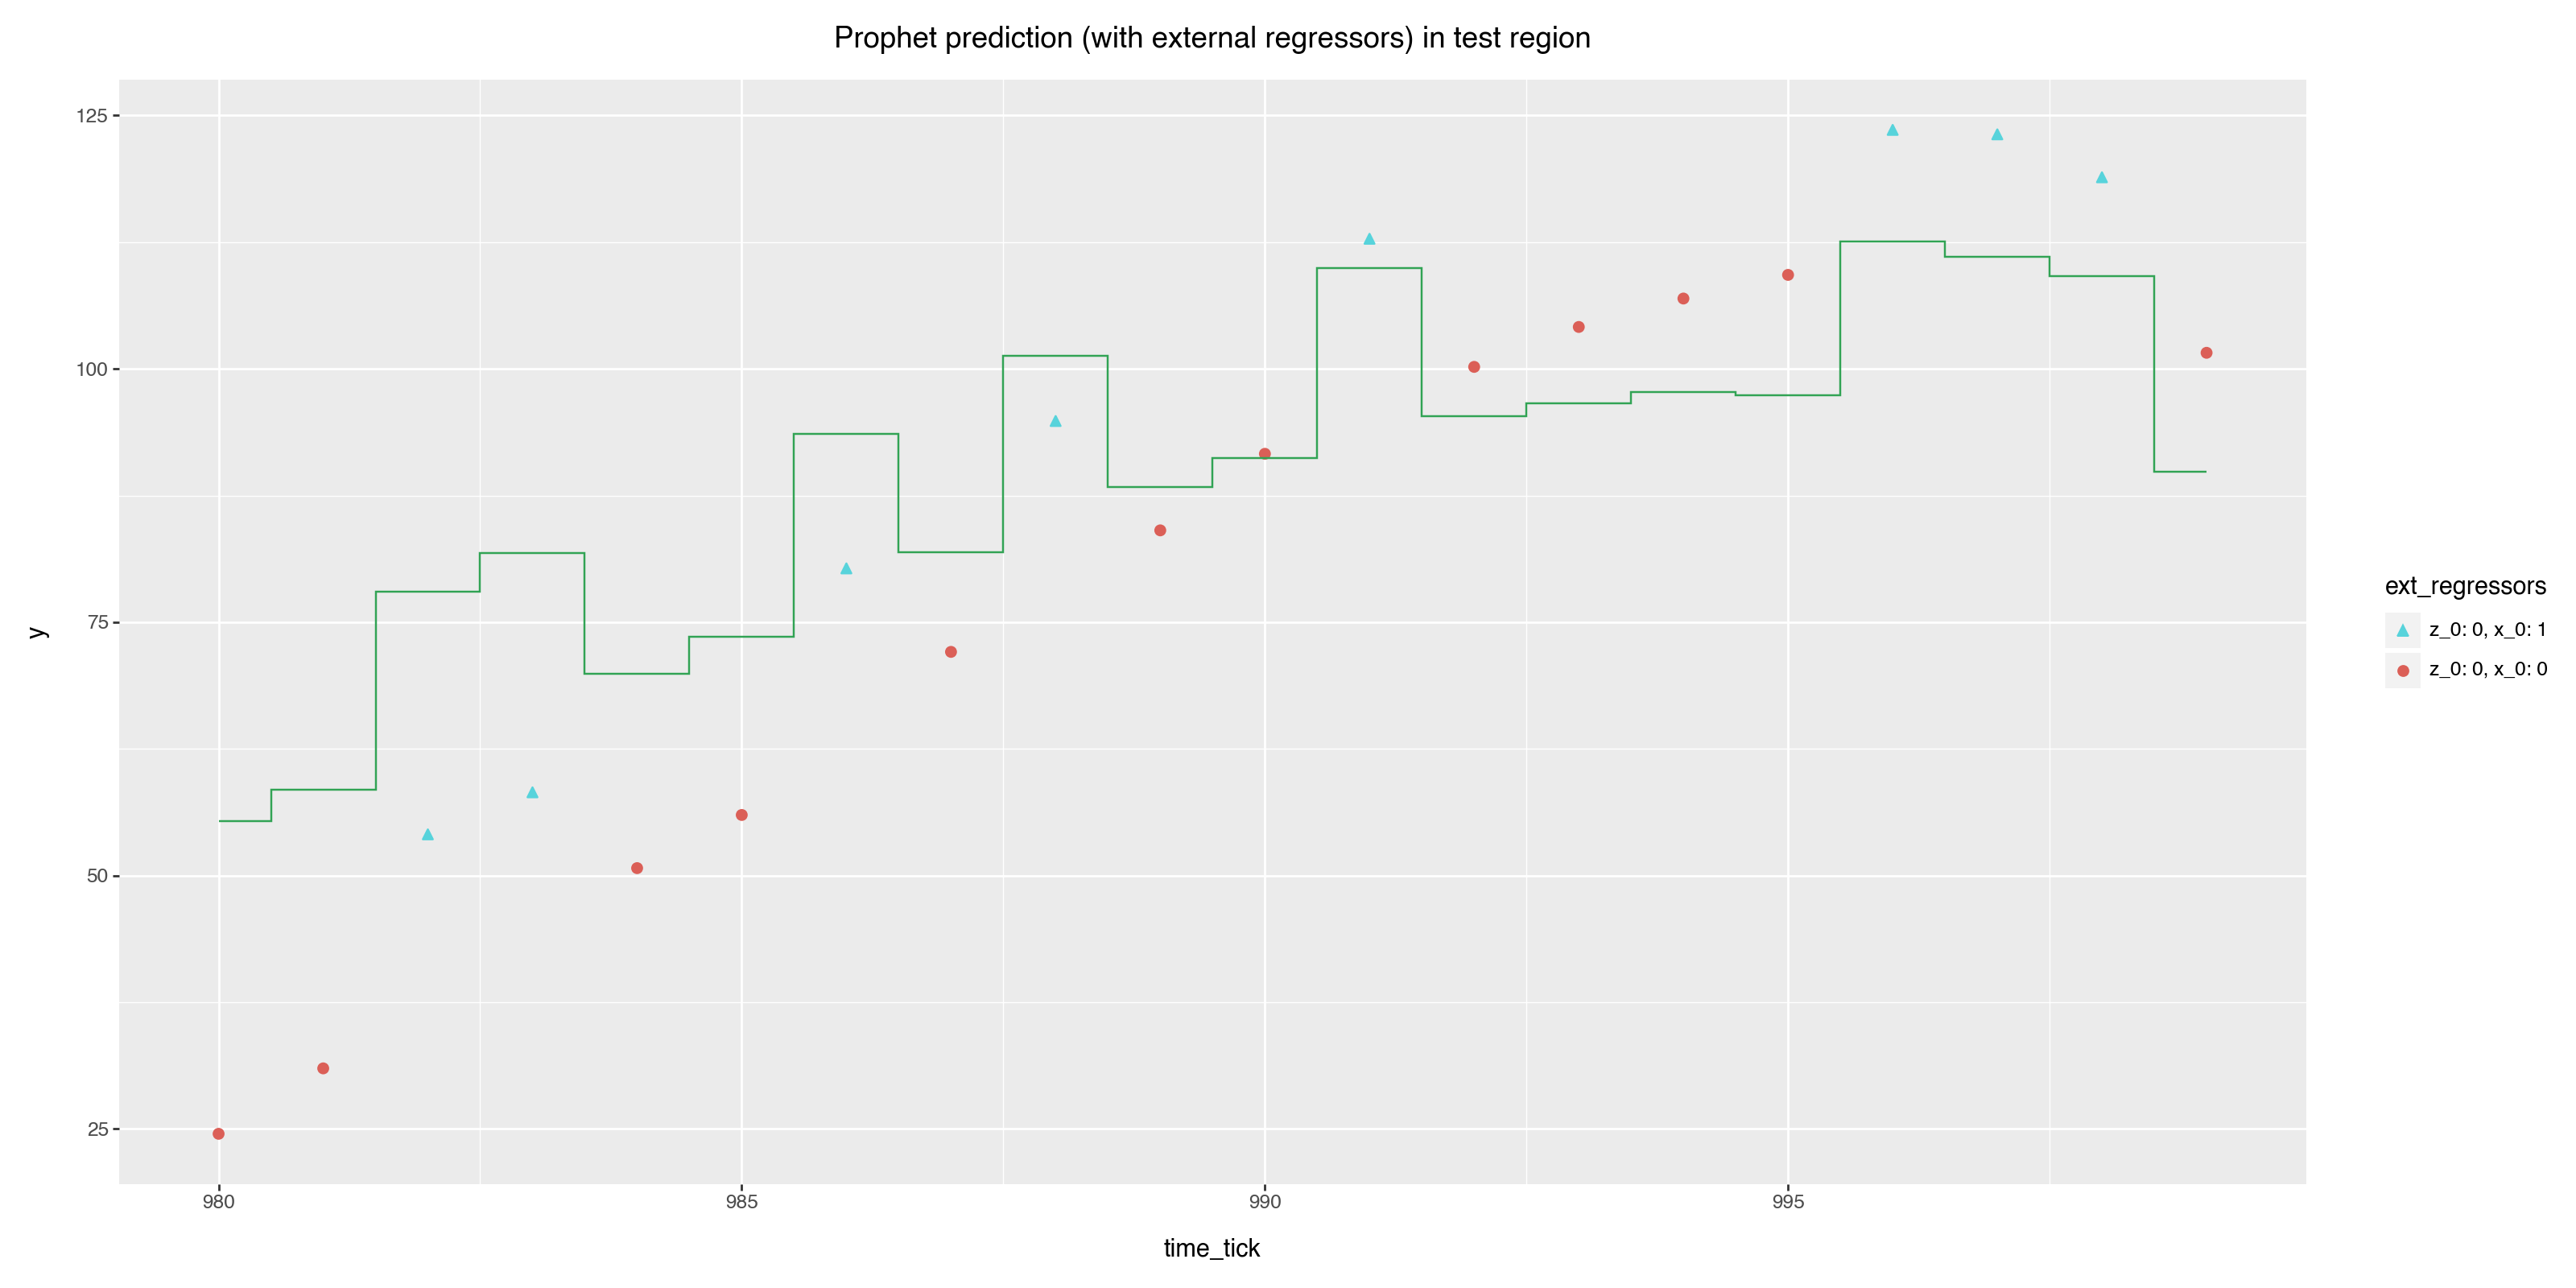

In [24]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(
        aes(y="y", shape="ext_regressors", color="ext_regressors"),
        size=2,
    )
    + geom_step(
        aes(y="Prophet prediction (with external regressors)"),
        color="#31a354",
        direction="mid",
    )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("Prophet prediction (with external regressors) in test region")
)

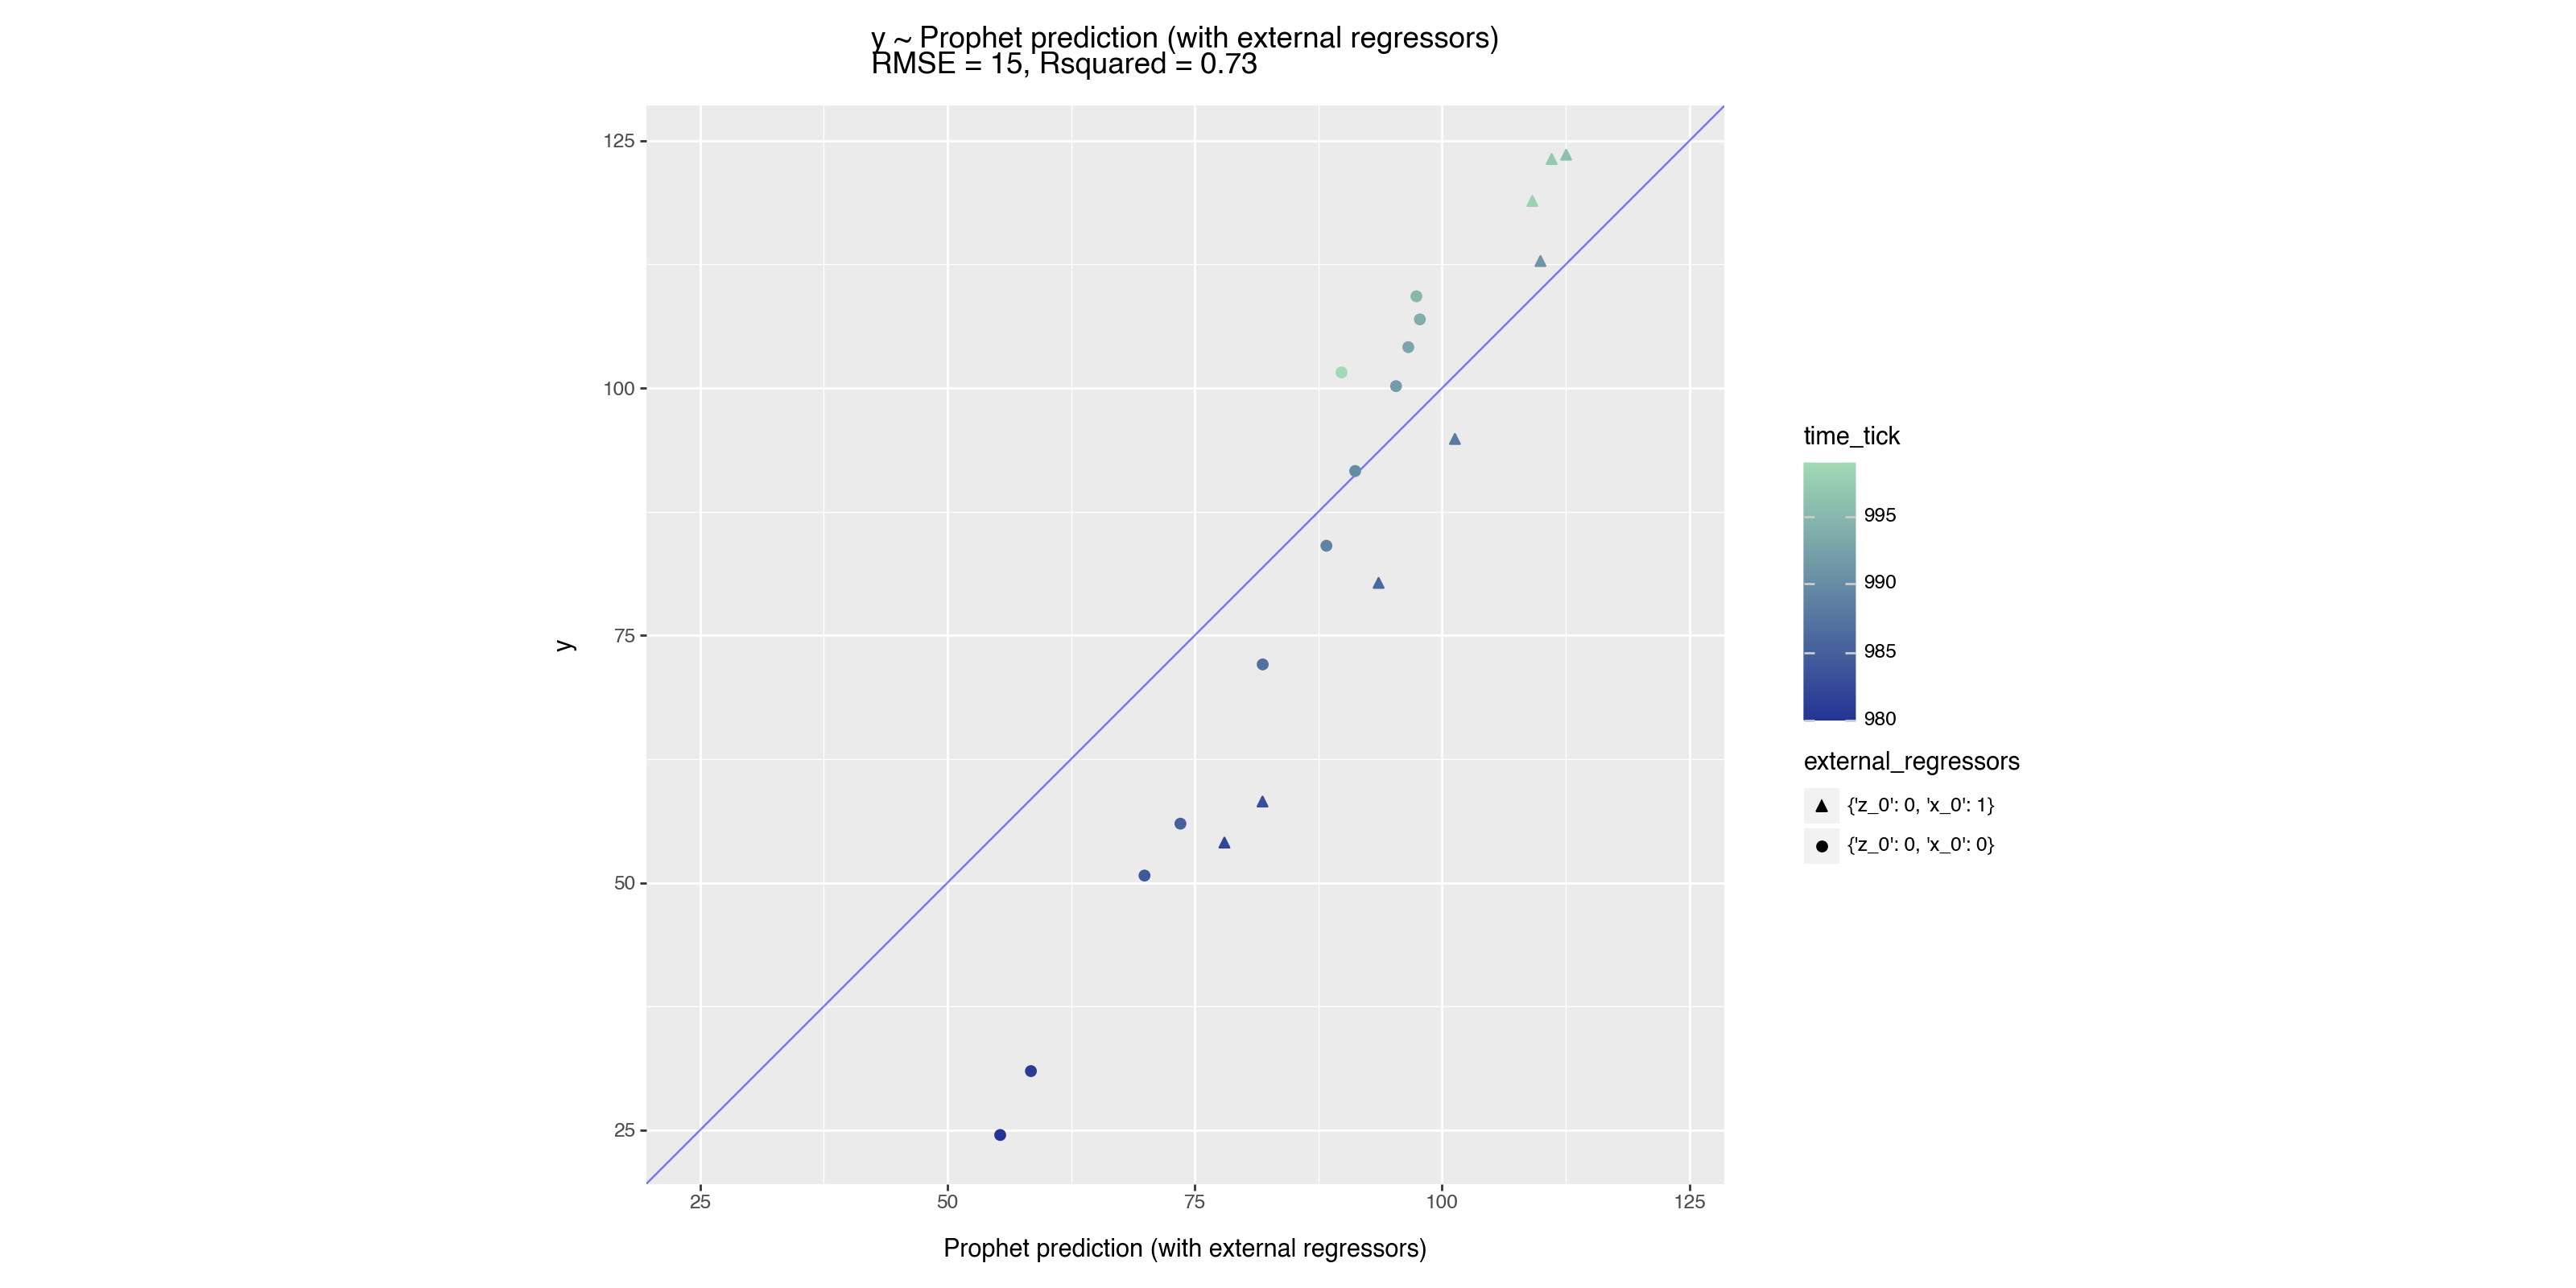

In [25]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["Prophet prediction (with external regressors)"]) == False, :
    ],
    result_name="Prophet prediction (with external regressors)",
    external_regressors=["z_0", "x_0"],
)